In [1]:
%matplotlib inline

import io, os, sys, types, datetime, pickle, warnings

import pandas as pd
import numpy as np
import scipy.optimize as opt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.pylab as pl

warnings.filterwarnings('ignore')

In [2]:
master_path = os.getcwd()
if master_path not in sys.path:
    sys.path.append(master_path)

In [3]:
def parse_folder_info(path):
    folders = [f for f in os.listdir(path) if not os.path.isfile(os.path.join(path, f))]
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    if('.DS_Store' in files):
        files.remove('.DS_Store')
    if('._.DS_Store' in files):
        files.remove('._.DS_Store')
    return folders, files

In [4]:
def get_time_columns(columns):
    time_str = []
    time_datetime = []
    for col in columns:
        if col[0].isnumeric():
            time_str.append(col)
            time_datetime.append(datetime.datetime.strptime(col, '%m/%d/%y'))
    return time_str, time_datetime

In [5]:
def format_fn(tick_val, tick_pos):
    if(tick_val >= 0 and tick_val < len(time_str)):
        return time_str[int(tick_val)]
    else:
        return int(tick_val)

In [6]:
def autolabel(rects, ax, str_format):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(str_format.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [7]:
def exp_growth(t, r, x0):
#     return np.log10(x0) + t * np.log10(1+r)
    return x0 * (1 + r) ** t

In [8]:
def logistic_growth(t, r, K, P0):
    return K / (1 + (K - P0)/P0 * np.exp(-r*t))

In [9]:
def get_moving_avg(arr, num):
    if(len(arr.shape) == 2):
        moving_avg = np.zeros((arr.shape[0]-num-1, arr.shape[1]))
        for i in range(1, arr.shape[0]-num):
            moving_avg[i-1,:] = np.mean(arr[i:i+num,:], axis = 0) / np.mean(arr[i-1:i+num-1,:], axis = 0)
        moving_avg[~np.isfinite(moving_avg)] = 0
    elif(len(arr.shape) == 1):
        moving_avg = np.zeros((arr.shape[0]-num-1))
        for i in range(1, arr.shape[0]-num):
            moving_avg[i-1] = np.mean(arr[i:i+num]) / np.mean(arr[i-1:i+num-1])
        moving_avg[~np.isfinite(moving_avg)] = 0
    return moving_avg
         

In [10]:
def reshape_dataframe(df, time_str):
    if('Confirmed' in df.index):
        df = df.transpose()
        df.rename_axis('Date', inplace = True)
        df['Active'] = df['Confirmed'] - (df['Deaths'] + df['Recovered'])
        df['Fatality_rate'] = df['Deaths']/df['Confirmed'] * 100
        df['Recovered_prop'] = df.Recovered/(df.Deaths + df.Recovered) * 100
        df['Death_prop'] = df.Deaths/(df.Deaths + df.Recovered) * 100
    else:
        df.rename(columns = {df.columns[0]:'Confirmed'}, inplace = True)
        df.rename_axis('Date', inplace = True)
    df['Daily'] = df['Confirmed'].diff()
    l1 = df.loc[time_str[2:],'Daily'].to_list()
    l2 = df.loc[time_str[1:-1],'Daily'].to_list()
    df.loc[time_str[2:],'GF'] = np.divide(l1, l2)
    df['GF_rolling_thr'] = df.GF.rolling(window = 3).mean()
    df[~np.isfinite(df)] = 0
    df['GF_rolling'] = df.GF.rolling(window = 3).mean()
    df[~np.isfinite(df)] = 0
    return df

In [78]:
def get_growth_rate(ctry, df_confirmed, time_str):
    x = np.arange(len(time_str))
    y = df_confirmed.loc[ctry,time_str].to_list()

    ind_t0 = y.index(next(filter(lambda x: x!=0, y)))
    t = np.arange(len(time_str))[ind_t0:] - ind_t0
    p_t = df_confirmed.loc[ctry,time_str].to_numpy()[ind_t0:]
    r = []
    try:
        popt_log, pcov_log = opt.curve_fit(logistic_growth,  t,  p_t, maxfev=100000)
        r.append(popt_log[0])
    except RuntimeError:
        r.append(np.inf)
    try:
        popt_log1, pcov_log1 = opt.curve_fit(logistic_growth,  t,  p_t, p0 = (0.1, 100, 1), maxfev=100000)
        r.append(popt_log1[0])
    except RuntimeError:
        r.append(np.inf)
    return np.min(r)

In [12]:
"""Get Data"""

'Get Data'

In [13]:
cat_color = {'Confirmed':'tab:blue', 'Deaths':'tab:orange', 'Recovered':'tab:green', 'Active':'tab:red'}

In [14]:
path_time_series = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_time_series')
path_daily = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_daily_reports')
today_csv = '03-14-2020.csv'
today = '3/14/20'
folders, files = parse_folder_info(path_time_series)
df_time_series = pd.DataFrame()
# df_time_series_reorged = pd.DataFrame(columns = ['Country/Region', 'Province/State', 'Date', 'Category', 'Number'])
for file_name in files:
    if('.csv' in file_name):
        df_current = pd.read_csv(os.path.join(path_time_series, file_name))        
        category = file_name[21:file_name.index('.csv')]
        print(category)
        df_current.loc[:,'Category'] = category
        if df_time_series.empty:
            df_time_series = df_current
        else:
            df_time_series = df_time_series.append(df_current, ignore_index = True)
time_str, time_datetime = get_time_columns(df_time_series.columns)
df_today = pd.read_csv(os.path.join(path_daily, today_csv))

df_time_series.loc[df_time_series.loc[:,'Province/State'].isna(),'Province/State'] = 'N/A'
df_today.loc[df_today.loc[:,'Province/State'].isna(), 'Province/State'] = 'N/A'
# df_time_series.loc[:,'New Today'] = df_time_series.loc[:,time_str[-1]] - df_time_series.loc[:,time_str[-2]]

Recovered
Deaths
Confirmed


In [15]:
### fix 3/12/20 datapoints

In [16]:
alt_cols = ['3/12/20', '3/15/20']

In [17]:
df_alteration = pd.read_csv(os.path.join(master_path, 'time_series_19-covid_alteration.csv'))
df_alteration.set_index('Country/Region', inplace = True)

In [18]:
for ctry in df_alteration.index:
    ind = (df_time_series['Category'] == 'Confirmed') & (df_time_series['Country/Region'] == ctry)
    if(np.sum(ind) > 1):
        ind = ind & (df_time_series['Province/State'] == ctry)
    for col in alt_cols:
        if not pd.isna(df_alteration.loc[ctry, col]):
            df_time_series.loc[ind, col] = df_alteration.loc[ctry, col]

In [19]:
""" Total Recovered, death, and confirmed """

' Total Recovered, death, and confirmed '

In [20]:
df_total = df_time_series.groupby('Category').sum().loc[:,time_str]
df_mc = df_time_series.groupby('Country/Region').get_group('China').groupby('Category').sum().loc[:,time_str]
df_row = df_total - df_mc
df_hb = df_time_series.groupby('Country/Region').get_group('China').groupby('Province/State').get_group('Hubei').groupby('Category').sum().loc[:,time_str]
df_co = df_mc - df_hb

In [21]:
df_total = reshape_dataframe(df_total, time_str)
df_mc = reshape_dataframe(df_mc, time_str)
df_row = reshape_dataframe(df_row, time_str)
df_hb = reshape_dataframe(df_hb, time_str)
df_co = reshape_dataframe(df_co, time_str)

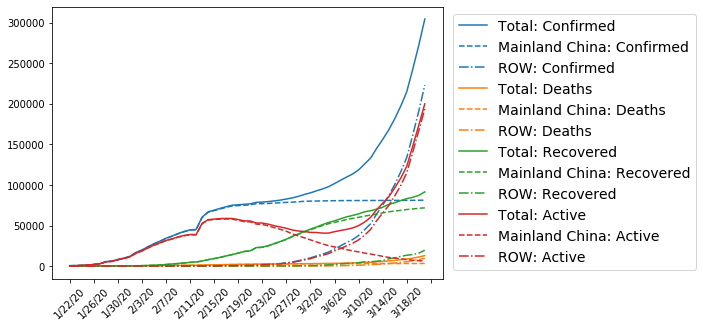

In [22]:
fig, ax1 = plt.subplots(1,1,figsize = (7,5))
for cat in cat_color:
    ax1.plot(df_total.loc[:,cat], color = cat_color[cat])
    ax1.plot(df_mc.loc[:,cat], '--', color = cat_color[cat])
    ax1.plot(df_row.loc[:,cat], '-.', color = cat_color[cat])
legend = ['Total: Confirmed',
         'Mainland China: Confirmed',
          'ROW: Confirmed',
         'Total: Deaths',
         'Mainland China: Deaths',
          'ROW: Deaths',
         'Total: Recovered',
         'Mainland China: Recovered',
          'ROW: Recovered',
         'Total: Active',
         'Mainland China: Active',
         'ROW: Active']
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
# ax1.set_title('Total', size = 18)
plt.legend(legend, bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, fontsize = 14)

In [23]:
x = np.arange(len(time_str))
y = np.zeros((len(time_str), 2))

y[:,0] = df_mc.Confirmed.to_list()
y[:,1] = df_row.Confirmed.to_list()

popt_exp = []
popt_log = []
for i in [0, 1]:
    p, cov = opt.curve_fit(exp_growth,  x,  y[:,i], p0 = (0.1, 100), maxfev=100000)
    popt_exp.append(list(p))
    p, cov = opt.curve_fit(logistic_growth,  x,  y[:,i], p0 = (0.1, 100, 1), maxfev=100000)
    popt_log.append(list(p))

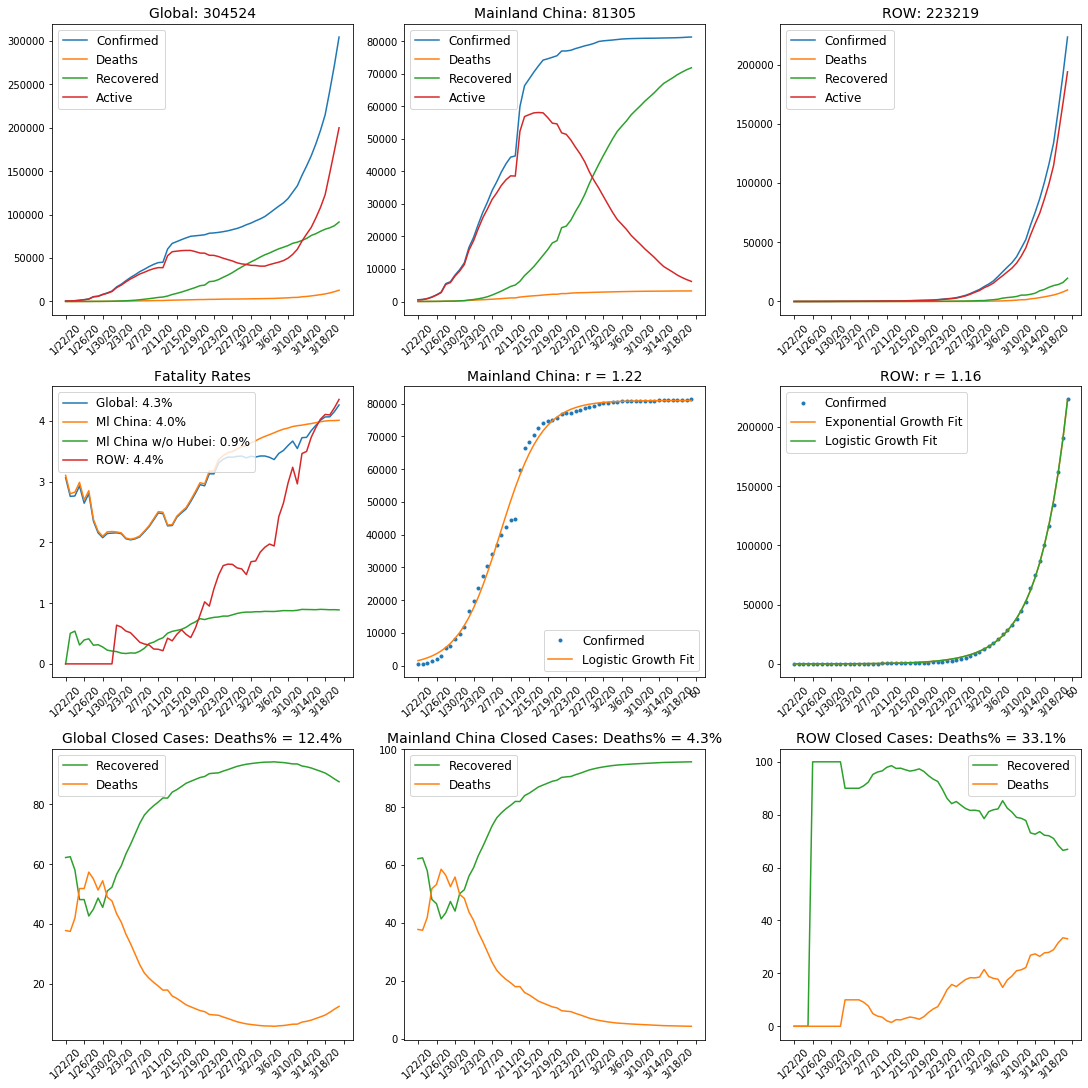

In [24]:
cat_cols = list(cat_color.keys())

fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3,3)

title_size = 14
legend_size = 12

### total confirmed/recovered/death/active
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_total[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cat_cols, fontsize = legend_size)
ax1.set_title(f"Global: {int(df_total.loc[time_str[-1], 'Confirmed'])}", size = title_size)

### mainland china confirmed/recovered/death/active
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_mc[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = legend_size)
ax2.set_title(f'Mainland China: {int(df_mc.loc[time_str[-1], "Confirmed"])}', size = title_size)

### rest of the world confirmed/recovered/death/active
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(df_row[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(cat_cols, fontsize = legend_size)
ax3.set_title(f'ROW: {int(df_row.loc[time_str[-1], "Confirmed"])}', size = title_size)

### fatality rates
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(df_total.loc[:,'Fatality_rate'])
ax4.plot(df_mc.loc[:,'Fatality_rate'])
ax4.plot(df_co.loc[:,'Fatality_rate'])
ax4.plot(df_row.loc[:,'Fatality_rate'])
plt.legend([f'Global: {df_total.Fatality_rate[-1]:.1f}%',
            f'Ml China: {df_mc.Fatality_rate[-1]:.1f}%',
            f'Ml China w/o Hubei: {df_co.Fatality_rate[-1]:.1f}%',
            f'ROW: {df_row.Fatality_rate[-1]:.1f}%'
           ], fontsize = legend_size)
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.set_title('Fatality Rates', fontsize = title_size)

### mainland China fit
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(x, y[:,0], '.')
ax5.plot(x, logistic_growth(x, popt_log[0][0], popt_log[0][1], popt_log[0][2]))
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(['Confirmed', 'Logistic Growth Fit'], fontsize = legend_size)
ax5.set_title(f'Mainland China: r = {popt_log[0][0]+1:.2f}', fontsize = title_size)

### ROW fit
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(x, y[:,1], '.')
ax6.plot(x, exp_growth(x, popt_exp[1][0], popt_exp[1][1]))
ax6.plot(x, logistic_growth(x, popt_log[1][0], popt_log[1][1], popt_log[1][2]))
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.tick_params(axis = 'x', labelrotation = 45)
ax6.legend(['Confirmed', 'Exponential Growth Fit', 'Logistic Growth Fit'], fontsize = legend_size)
ax6.set_title(f'ROW: r = {popt_log[1][0]+1:.2f}', fontsize = title_size)
              
### total closed cases
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(df_total.Recovered_prop, color = cat_color['Recovered'])
ax7.plot(df_total.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax7.xaxis.set_major_locator(myLocator)
ax7.tick_params(axis = 'x', labelrotation = 45)
ax7.legend(['Recovered', 'Deaths'], fontsize = legend_size)
ax7.set_title(f'Global Closed Cases: Deaths% = {df_total.Death_prop[-1]:.1f}%', size = title_size)

### mainland china closed cases
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(df_mc.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_mc.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(['Recovered', 'Deaths'], fontsize = legend_size)
ax8.set_title(f'Mainland China Closed Cases: Deaths% = {df_mc.Death_prop[-1]:.1f}%', size = title_size)

### rest of the world closed cases
ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(df_row.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_row.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(['Recovered', 'Deaths'], fontsize = legend_size)
_ = ax9.set_title(f'ROW Closed Cases: Deaths% = {df_row.Death_prop[-1]:.1f}%', size = title_size)

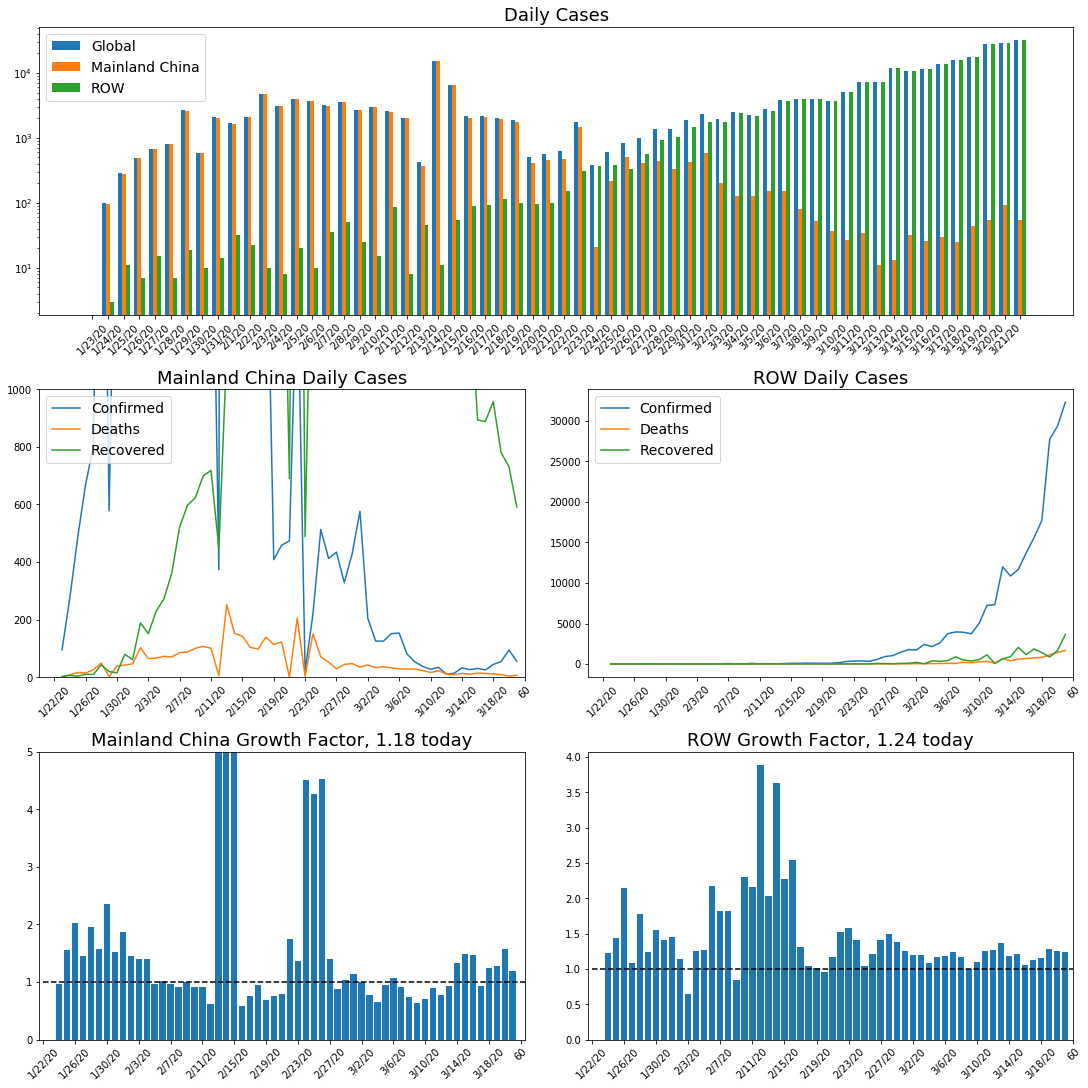

In [25]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3,2)

# ### Daily Confirmed cases
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(time_str))
width = 0.25

ax1.bar(x + 0, df_total.loc[:,'Daily'], width = width)
ax1.bar(x + width*1, df_mc.loc[:,'Daily'], width = width)
ax1.bar(x + width*2, df_row.loc[:,'Daily'], width = width)
ax1.set_yscale('log')
# ax4.set_ylim([0, 5000])
_ = ax1.set_xticks(x + width)
_ = ax1.set_xticklabels(time_str[1:])
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(['Global', 'Mainland China', 'ROW'], fontsize = 14, loc='upper left')
ax1.set_title('Daily Cases', size = 18)


### Mainland China daily confirmed/recovered/deaths/active
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(df_mc[cat_cols[:-1]].diff())
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.set_ylim([0, 1000])
ax2.set_xlim(right = len(time_str))
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = 14)
ax2.set_title('Mainland China Daily Cases', size = 18)

### ROW daily confirmed/recovered/deaths/active
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(df_row[cat_cols[:-1]].diff())
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.set_xlim(right = len(time_str))
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(cat_cols, fontsize = 14)
ax3.set_title('ROW Daily Cases', size = 18)


# ### Mainland China Growth Factor
ax5 = fig.add_subplot(gs[2, 0])

x = np.arange(0, len(time_str))
x1 = np.arange(0, len(time_str) + 2)

ax5.bar(x, df_mc.GF_rolling)
ax5.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.set_xlim([-0.5, len(time_str)+0.5])
ax5.set_ylim(top = 5, bottom = 0)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.set_title(f'Mainland China Growth Factor, {df_mc.GF_rolling[-1]:.2f} today', size = 18)

### ROW Growth Factor
ax6 = fig.add_subplot(gs[2, 1])
ax6.bar(x, df_row.GF_rolling)
ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.set_xlim([-0.5, len(time_str)])
ax6.tick_params(axis = 'x', labelrotation = 45)
_ = ax6.set_title(f'ROW Growth Factor, {df_row.GF_rolling[-1]:.2f} today', size = 18)

In [26]:
"""US"""

'US'

In [27]:
df_US = df_time_series.groupby(['Country/Region']).get_group(('US'))
df_CA = pd.DataFrame()
df_DP = pd.DataFrame()
df_USmain = pd.DataFrame()
df_GP = pd.DataFrame()

for i in df_US.index:
    if ('CA' in df_US.loc[i, 'Province/State'] or 'California' in df_US.loc[i, 'Province/State']):
        if('(From Diamond Princess)' not in df_US.loc[i, 'Province/State']) :
            df_CA = df_CA.append(df_US.loc[i,:])
    if('Diamond Princess'in df_US.loc[i, 'Province/State']) :
        df_DP = df_DP.append(df_US.loc[i,:])
    if('Grand Princess' in df_US.loc[i, 'Province/State']):
        df_GP = df_GP.append(df_US.loc[i,:])
    else:
        df_USmain = df_USmain.append(df_US.loc[i,:])
df_US_ori = df_US

In [28]:
df_US = reshape_dataframe(df_US.groupby('Category').sum().loc[:,time_str], time_str)
df_CA = reshape_dataframe(df_CA.groupby('Category').sum().loc[:,time_str], time_str)
df_USmain = reshape_dataframe(df_USmain.groupby('Category').sum().loc[:,time_str], time_str)
df_DP = reshape_dataframe(df_DP.groupby('Category').sum().loc[:,time_str], time_str)
df_GP = reshape_dataframe(df_GP.groupby('Category').sum().loc[:,time_str], time_str)

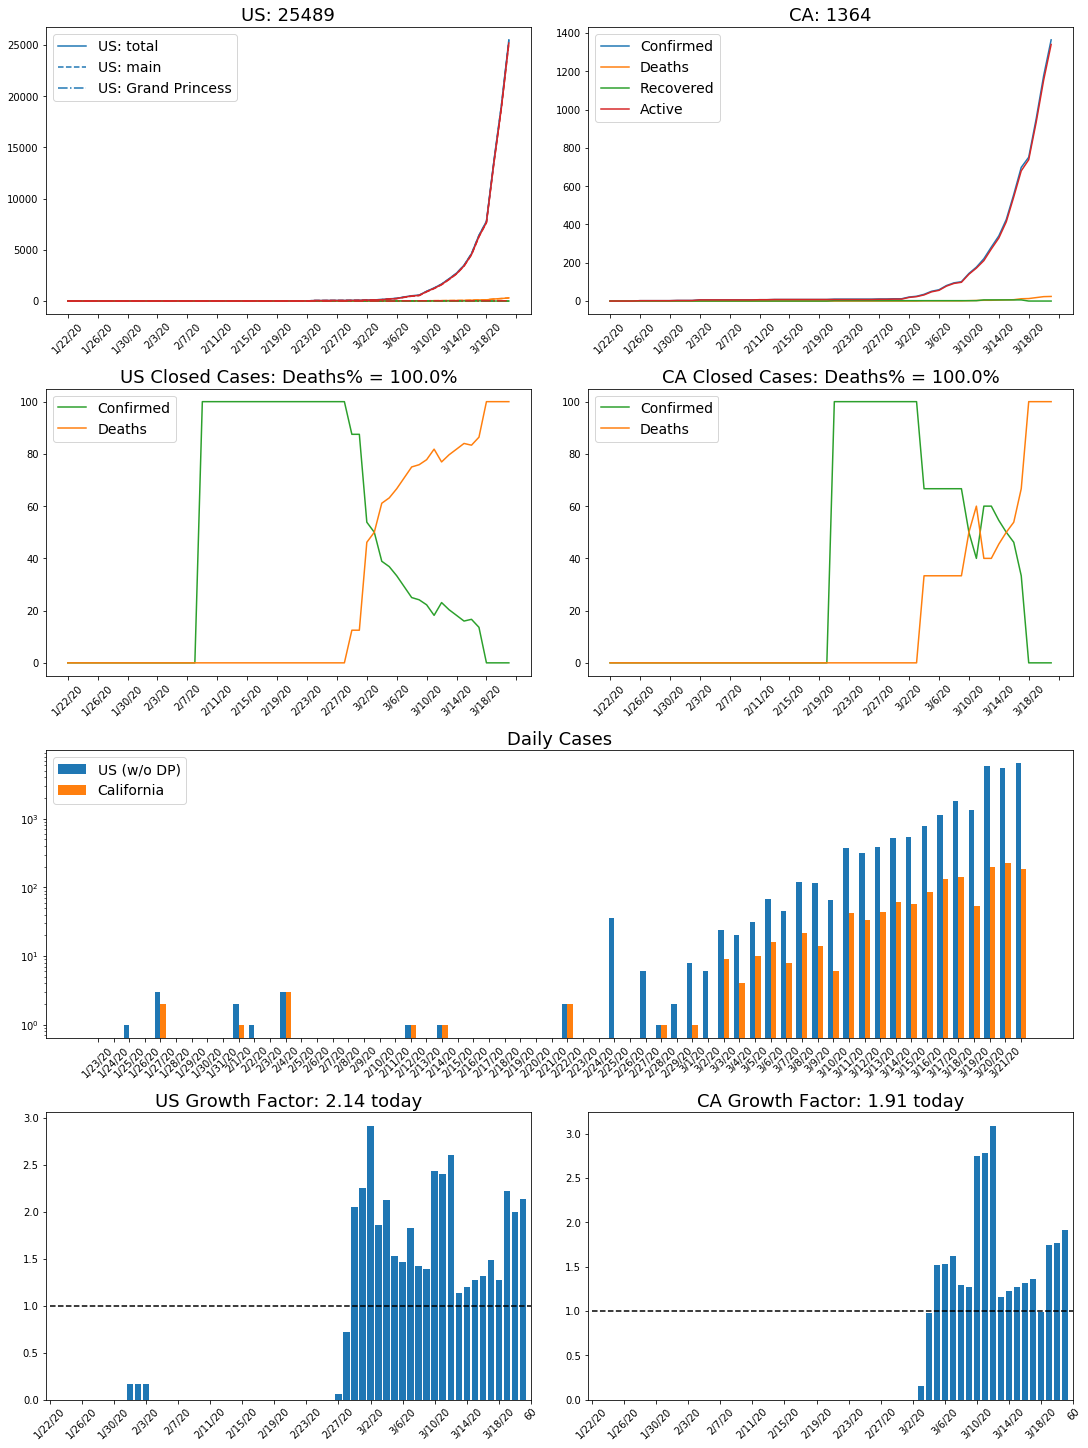

In [29]:
fig = plt.figure(figsize = (15, 20), constrained_layout=True)
gs = fig.add_gridspec(4,2)

### US confirmed/recovered/deaths/active
ax1 = fig.add_subplot(gs[0, 0])
for cat in cat_color:
    ax1.plot(df_US.loc[:,cat], color = cat_color[cat])
    ax1.plot(df_USmain.loc[:,cat], '--', color = cat_color[cat])
    ax1.plot(df_GP.loc[:,cat], '-.', color = cat_color[cat])
legend = ['US: total', 'US: main', 'US: Grand Princess']
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(legend, fontsize = 14)
ax1.set_title(f'US: {int(df_US.loc[time_str[-1], "Confirmed"])}', size = 18)

              
### Ca confirmed/recovered/deaths/active
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_CA[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = 14)
ax2.set_title(f'CA: {int(df_CA.loc[time_str[-1], "Confirmed"])}', size = 18)

### US Closed cases      
ax8 = fig.add_subplot(gs[1, 0])
ax8.plot(df_US.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_US.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(cat_cols, fontsize = 14)
ax8.set_title(f'US Closed Cases: Deaths% = {df_US.Death_prop[-1]:.1f}%', size = 18)

### CA Closed cases
ax9 = fig.add_subplot(gs[1, 1])
ax9.plot(df_CA.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_CA.Death_prop, color = cat_color['Deaths'])
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(cat_cols, fontsize = 14)
ax9.set_title(f'CA Closed Cases: Deaths% = {df_CA.Death_prop[-1]:.1f}%', size = 18)
              
### Daily new cases              
ax3 = fig.add_subplot(gs[2, :])
x = np.arange(len(time_str))
width = 0.35
rects1 = ax3.bar(x - width/2, df_USmain.loc[:,'Daily'], width = width)
rects2 = ax3.bar(x + width/2, df_CA.loc[:,'Daily'], width = width)
ax3.set_yscale('log')
# ax3.set_yscale('linear')
# ax3.set_ylim([0, 1000])
_ = ax3.set_xticks(x)
_ = ax3.set_xticklabels(time_str[1:])
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['US (w/o DP)', 'California'], fontsize = 14)
ax3.set_title('Daily Cases', size = 18)

              
### US growth factors
ax4 = fig.add_subplot(gs[3, 0])
              
x = np.arange(len(time_str))
x1 = np.arange(0, len(time_str) + 2)
              
ax4.bar(x, df_USmain.GF_rolling)
ax4.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ax4.set_xlim([-0.5, len(time_str)])
ax4.tick_params(axis = 'x', labelrotation = 45)
_ = ax4.set_title(f'US Growth Factor: {df_USmain.GF_rolling[-1]:.2f} today', size = 18)

              
### CA growth factors
ax5 = fig.add_subplot(gs[3, 1])
              
ax5.bar(x, df_CA.GF_rolling)
ax5.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.set_xlim([-0.5, len(time_str)])
ax5.tick_params(axis = 'x', labelrotation = 45)
_ = ax5.set_title(f'CA Growth Factor: {df_CA.GF_rolling[-1]:.2f} today', size = 18)

In [30]:
df_US_1p3a = pd.read_csv('time_series_19-covid_US_1p3a.csv')
df_US_1p3a.set_index('Date', inplace = True)

In [31]:
ys = np.zeros((len(time_str), 4))
x = np.arange(len(time_str))

ys[:,0] = df_US.loc[time_str, 'Confirmed'].to_numpy()
ys[:,1] = df_US_1p3a.loc[time_str, 'US'].to_numpy()
ys[:,2] = df_CA.loc[time_str, 'Confirmed'].to_numpy()
ys[:,3] = df_US_1p3a.loc[time_str, 'CA'].to_numpy()

res1 = df_US[df_US.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
res2 = df_CA[df_CA.GF_rolling_thr != 0.0].bfill(axis=1).index[0]

ind1_t0 = max(0, time_str.index(res1)-3)
ind2_t0 = max(0, time_str.index(res2)-5)

t1 = np.arange(len(time_str))[ind1_t0:]- ind1_t0
t2 = np.arange(len(time_str))[ind2_t0:]- ind2_t0

Text(0.5, 1.0, 'CA: growth rate 0.22/0.24')

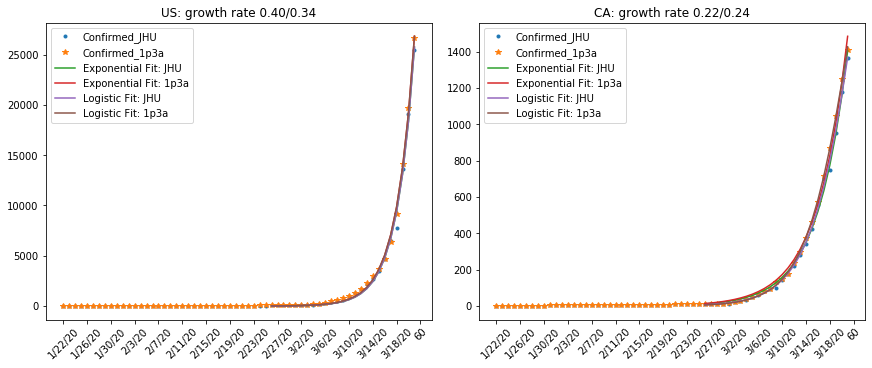

In [32]:
future = 0
x1 = np.arange((len(t1) + future))

fig = plt.figure(figsize = (12, 5), constrained_layout=True)
gs = fig.add_gridspec(1, 2)

### US
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x, ys[:,0], '.')
ax1.plot(x, ys[:,1], '*')
if(future == 0):
    r_exp = 0
    for i in [0,1]:
        popt, pcov = opt.curve_fit(exp_growth, t1, ys[ind1_t0:,i], maxfev = 10000)
        ax1.plot(x1 + ind1_t0, exp_growth(x1, popt[0], popt[1]))
        r_exp += popt[0]
    r_exp = r_exp/2
else:
    r_exp = np.nan
r_log = 0
for i in [0,1]:
    popt, pcov = opt.curve_fit(logistic_growth, t1, ys[ind1_t0:,i], maxfev = 10000)
    ax1.plot(x1 + ind1_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
    r_log += popt[0]
r_log = r_log/2
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.set_yscale('linear')
# ax1.set_ylim([0, 3*10**11])
ax1.tick_params(axis = 'x', labelrotation = 45)
if(future == 0):
    ax1.legend(['Confirmed_JHU', 
                'Confirmed_1p3a',
                'Exponential Fit: JHU',
                'Exponential Fit: 1p3a',
                'Logistic Fit: JHU', 
                'Logistic Fit: 1p3a'])
else:
    ax1.legend(['Confirmed_JHU', 
                'Confirmed_1p3a',
                'Logistic Fit: JHU', 
                'Logistic Fit: 1p3a'])
ax1.set_title(f'US: growth rate {r_exp:.2f}/{r_log:.2f}')

## CA
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(x, ys[:,2], '.')
ax2.plot(x, ys[:,3], '*')
if(future == 0):
    r_exp = 0
    for i in [2,3]:
        popt, pcov = opt.curve_fit(exp_growth, t1, ys[ind1_t0:,i], maxfev = 10000)
        ax2.plot(x1 + ind1_t0, exp_growth(x1, popt[0], popt[1]))
        r_exp += popt[0]
    r_exp = r_exp/2
else:
    r_exp = np.nan
r_log = 0
for i in [2,3]:
    popt, pcov = opt.curve_fit(logistic_growth, t1, ys[ind1_t0:,i], p0 = [0.1, 100, 1], maxfev = 10000)
    ax2.plot(x1 + ind1_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
    r_log += popt[0]
r_log = r_log/2
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.set_yscale('linear')
# ax.set_ylim([0, 60000])
ax2.tick_params(axis = 'x', labelrotation = 45)
if(future == 0):
    ax2.legend(['Confirmed_JHU', 
                'Confirmed_1p3a',
                'Exponential Fit: JHU',
                'Exponential Fit: 1p3a',
                'Logistic Fit: JHU', 
                'Logistic Fit: 1p3a'])
else:
    ax2.legend(['Confirmed_JHU', 
                'Confirmed_1p3a',
                'Logistic Fit: JHU', 
                'Logistic Fit: 1p3a'])
ax2.set_title(f'CA: growth rate {r_exp:.2f}/{r_log:.2f}')

In [58]:
"""US by states"""

'US by states'

In [59]:
df_confirmed = df_US_ori.groupby('Category').get_group('Confirmed').groupby('Province/State').sum()[time_str]
df_recovered = df_US_ori.groupby('Category').get_group('Recovered').groupby('Province/State').sum()[time_str]
df_deaths = df_US_ori.groupby('Category').get_group('Deaths').groupby('Province/State').sum()[time_str]
df_active = df_confirmed - (df_recovered + df_deaths)
df_confirmed['New_Today'] = df_confirmed[time_str[-1]] - df_confirmed[time_str[-2]]

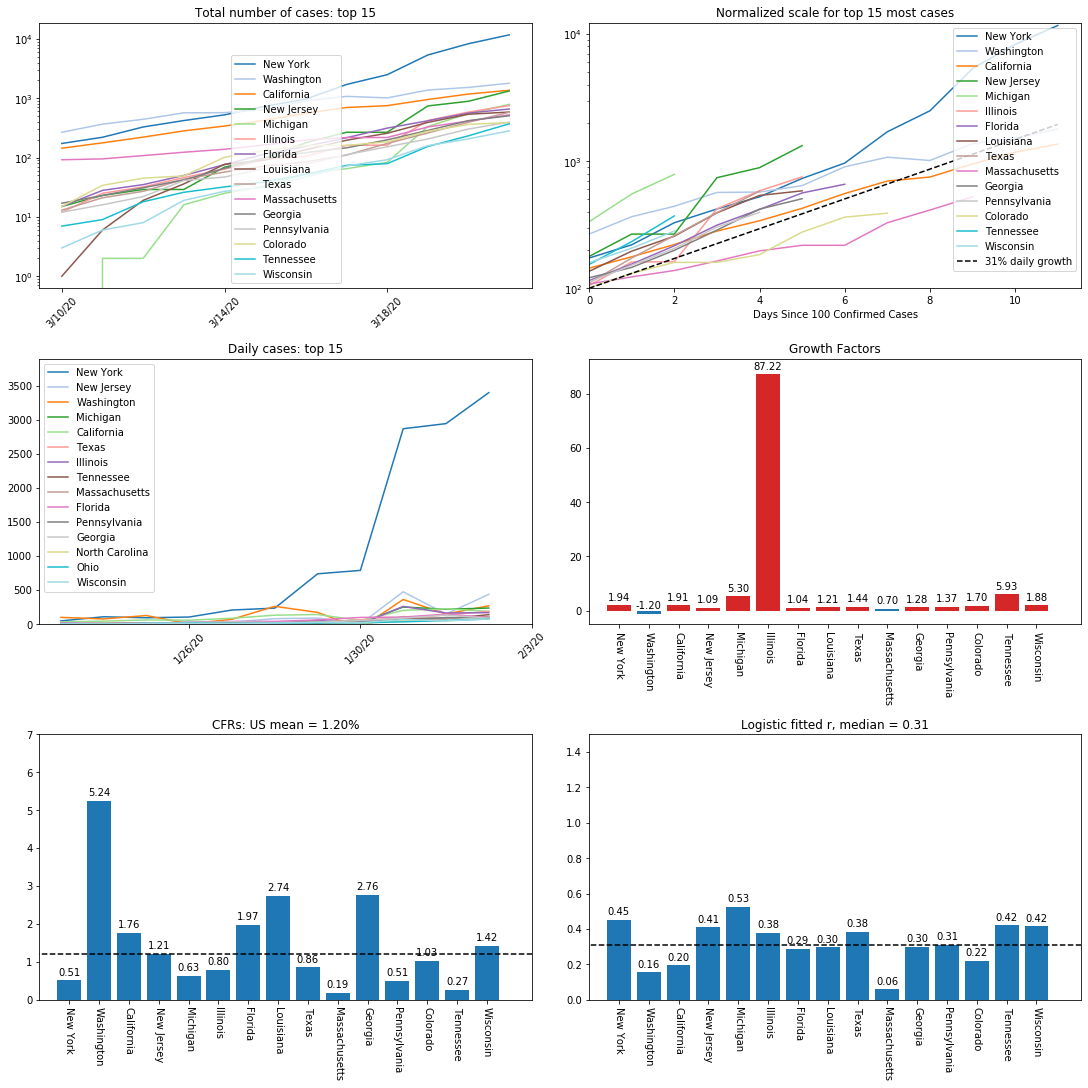

In [79]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3, 2)
num_states = 15

### get states list
ind_t0 = time_str.index('3/10/20')
time_plot = time_str[ind_t0:]

## r for logistic growth fit
ax6 = fig.add_subplot(gs[2, 1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_confirmed.index[0:num_states])

x = np.arange(len(states))
x1 = np.arange(-2, len(x)+2)
y = []
for i in x:
    ctry = states[i]
    y.append(get_growth_rate(ctry, df_confirmed, time_plot))
y = np.array(y)
r_median = np.median(y)
rects = ax6.bar(x, y)
ax6.plot(x1, np.full(len(x1), np.median(y)), '--', color = 'k')
a = ax6.set_xticks(x)
a = ax6.set_xticklabels(states)
ax6.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax6, '{:.2f}')
# ymax = np.ceil(np.max(y)) + 0.5
ymax = 1.5
ax6.set_ylim([0, ymax])
ax6.set_xlim([-1, len(x) + 0.5])
a = ax6.set_title(f'Logistic fitted r, median = {np.median(y):.2f}')

### total number
ax1 = fig.add_subplot(gs[0, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_confirmed.index[0:num_states])
df_plot = df_confirmed.loc[states,time_plot]

colors = pl.cm.tab20(np.linspace(0,1,len(states)))
for i, ctr in enumerate(states):
    ax1.plot(df_plot.loc[ctr,:], color = colors[i])

ax1.legend(states)
ax1.set_yscale('log')
# plt.ylim(top = 2000)
ax1.set_title(f'Total number of cases: top {num_states}')
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)

### normalize axis
ax2 = fig.add_subplot(gs[0, 1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_confirmed.index[0:num_states])
df_plot = df_confirmed.loc[states,time_plot]

colors = pl.cm.tab20(np.linspace(0,1,len(states)))
max_x = 0
for i, ctr in enumerate(states):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy())
    ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), color = colors[i])
    if(xi > max_x):
        max_x = xi
x = np.arange(max_x)
ax2.plot(x, 100 * (1 + r_median) ** x, ls='--', color='k')
ax2.legend(states + [f'{r_median*100:.0f}% daily growth'])
ax2.set_ylim(bottom = 100)
ax2.set_xlim(left = 0)
ax2.set_yscale('log')
ax2.set_xlabel('Days Since 100 Confirmed Cases')
ax2.set_title(f'Normalized scale for top {num_states} most cases')


### daily cases
ax3 = fig.add_subplot(gs[1, 0])

df_confirmed.sort_values(by = 'New_Today', inplace = True, ascending=False)
states = list(df_confirmed.index[0:num_states])

data = df_confirmed.loc[states,time_plot].to_numpy().transpose()
new_today = data[1:,:] - data[0:-1,:]
data_max = np.ceil(np.max(new_today.flatten())) + 500
x = np.arange(1, len(time_plot))

colors = pl.cm.tab20(np.linspace(0,1,len(states)))
for i, ctr in enumerate(states):
    ax3.plot(x, new_today[:,i], color = colors[i])

ax3.legend(states, loc = 'upper left')
ax3.set_yscale('linear')
ax3.set_ylim([0, data_max])
a = ax3.set_title(f'Daily cases: top {num_states}')
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.set_xlim(right = len(time_plot))
ax3.tick_params(axis = 'x', labelrotation = 45)

### growth factors
df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_confirmed.index[0:num_states])

df_gf = df_confirmed.loc[states,time_plot].transpose()
for ctry in states:
    df_ctry = pd.DataFrame(df_confirmed.loc[ctry,time_plot])
    df_ctry = reshape_dataframe(df_ctry, time_plot)
    df_gf[ctry] = df_ctry.GF_rolling

ax4 = fig.add_subplot(gs[1, 1])

x = np.arange(len(states))
y = df_gf.loc[time_plot[-1],:]

rects1 = ax4.bar(x[y<=1], y[y<=1], color = 'tab:blue')
rects2 = ax4.bar(x[y>1], y[y>1], color = 'tab:red')
a = ax4.set_xticks(x)
a = ax4.set_xticklabels(states)
ax4.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects1, ax4, '{:.2f}')
autolabel(rects2, ax4, '{:.2f}')
ymax = np.ceil(np.max(y)) + 5
ax4.set_ylim([-5, ymax])
a = ax4.set_title('Growth Factors')
ax4.set_xlim([-1, len(x) + 0.5])


### fatality rate
ax5 = fig.add_subplot(gs[2, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_confirmed.index[0:num_states])

fatal_rates = df_deaths.loc[states,time_plot] / df_confirmed.loc[states,time_plot] * 100
x = np.arange(len(states))
x1 = np.arange(-2, len(x)+2)
fr_total = df_US.Fatality_rate[-1]

rects = ax5.bar(x, fatal_rates.loc[:,time_plot[-1]])
ax5.plot(x1, np.full(len(x1), fr_total), '--', color = 'k')
a = ax5.set_xticks(x)
a = ax5.set_xticklabels(states)
ax5.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax5, '{:.2f}')
ymax = np.ceil(np.max(fatal_rates.loc[:,time_plot[-1]]) + 1)
ax5.set_ylim([0, ymax])
ax5.set_xlim([-1, len(x) + 0.5])
a = ax5.set_title(f'CFRs: US mean = {fr_total:.2f}%')

https://lmfit.github.io/lmfit-py/model.html

In [86]:
""" Outside Mainland China"""

' Outside Mainland China'

In [87]:
df_confirmed = df_time_series.groupby('Category').get_group('Confirmed').groupby('Country/Region').sum()[time_str]
df_recovered = df_time_series.groupby('Category').get_group('Recovered').groupby('Country/Region').sum()[time_str]
df_deaths = df_time_series.groupby('Category').get_group('Deaths').groupby('Country/Region').sum()[time_str]
df_active = df_confirmed - (df_recovered + df_deaths)
df_confirmed['New_Today'] = df_confirmed[time_str[-1]] - df_confirmed[time_str[-2]]

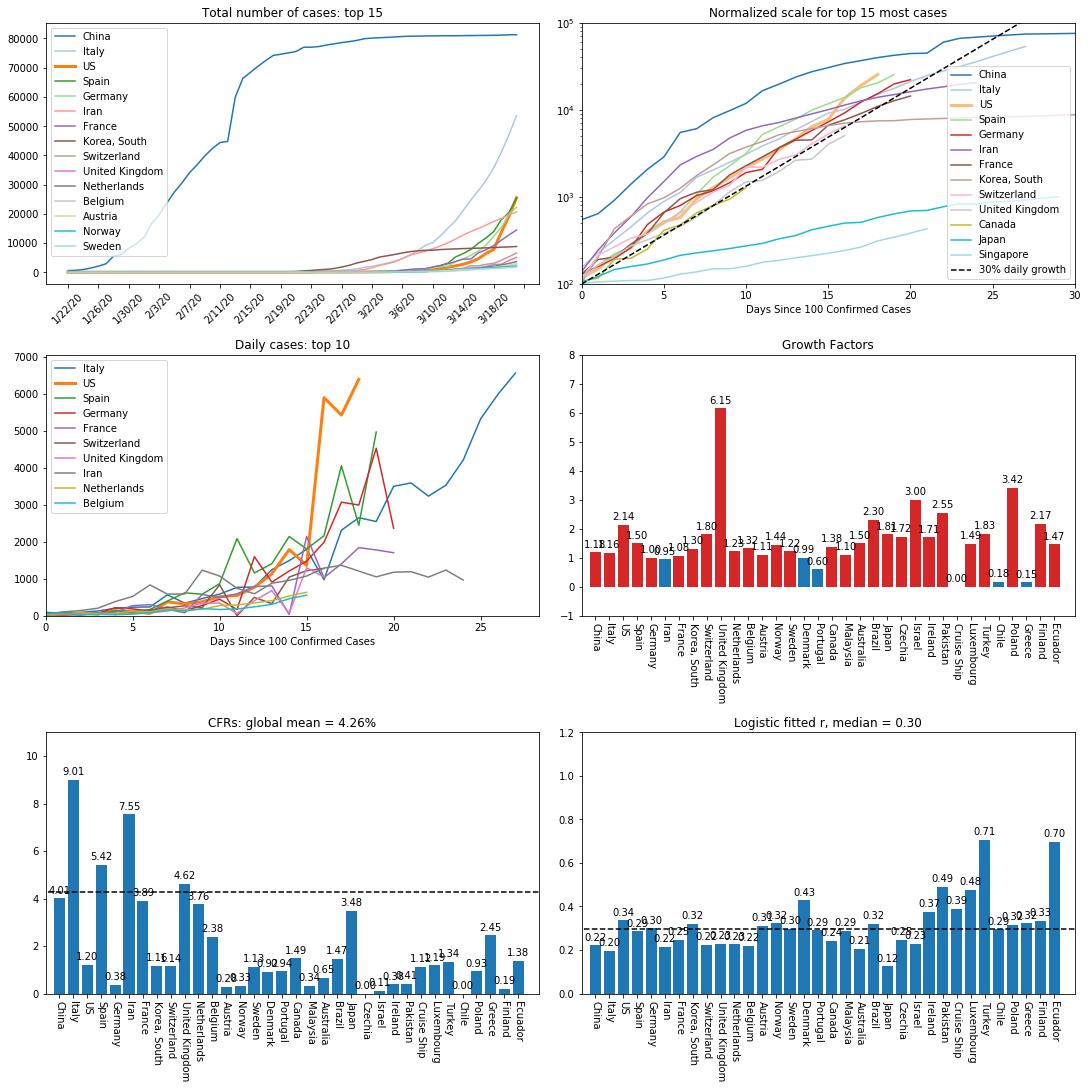

In [168]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3, 2)

## r for logistic growth fit
ax6 = fig.add_subplot(gs[2, 1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 500]

x = np.arange(len(countries))
x1 = np.arange(-2, len(x)+2)
y = []
for i in x:
    ctry = countries[i]
    y.append(get_growth_rate(ctry, df_confirmed, time_str))
y = np.array(y)
r_median = np.median(y)

rects = ax6.bar(x, y)
ax6.plot(x1, np.full(len(x1), np.median(y)), '--', color = 'k')
a = ax6.set_xticks(x)
a = ax6.set_xticklabels(countries)
ax6.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax6, '{:.2f}')
ymax = np.ceil(np.max(y)) + 0.2
ax6.set_ylim([0, ymax])
ax6.set_xlim([-1, len(x) + 0.5])
a = ax6.set_title(f'Logistic fitted r, median = {np.median(y):.2f}')

### total number
ax1 = fig.add_subplot(gs[0, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:15])
df_plot = df_confirmed.loc[countries,time_str]

colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
for i, ctr in enumerate(countries):
    if(ctr == 'US'):
        ax1.plot(df_plot.loc[ctr,:], color = colors[i], linewidth = 3)
    else:
        ax1.plot(df_plot.loc[ctr,:], color = colors[i])

ax1.legend(countries)
ax1.set_yscale('linear')
# plt.ylim(top = 2000)
ax1.set_title('Total number of cases: top 15')
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)

### normalize axis
ax2 = fig.add_subplot(gs[0, 1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:10])
countries += ['Canada','Japan', 'Singapore']

df_plot = df_confirmed.loc[countries,time_str]


colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
max_x = 0
for i, ctr in enumerate(countries):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy())
    if(xi > max_x):
        max_x = xi
    if(ctr == 'US'):
        ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), linewidth = 3, color = colors[i])
    else:
        ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), color = colors[i])
x = np.arange(max_x)
ax2.plot(x, 100 * (1+r_median) ** x, ls='--', color='k')
ax2.set_ylim([100, 10**5])
ax2.set_xlim([0, 30])
ax2.legend(countries + [f'{r_median*100:.0f}% daily growth'])
ax2.set_yscale('log')
ax2.set_xlabel('Days Since 100 Confirmed Cases')
ax2.set_title('Normalized scale for top 15 most cases')


### daily cases
ax3 = fig.add_subplot(gs[1, 0])

df_confirmed.sort_values(by = 'New_Today', inplace = True, ascending=False)
countries = list(df_confirmed.index[0:10])
# countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 100]

# data = df_confirmed.loc[countries,time_str].to_numpy().transpose()
# new_today = data[1:,:] - data[0:-1,:]
# data_max = np.ceil(np.max(new_today.flatten())) + 500
# x = np.arange(1, len(time_str))

colors = pl.cm.tab10(np.linspace(0,1,len(countries)))
max_x = 0
for i, ctr in enumerate(countries):
    yi = df_confirmed.loc[ctr,time_str].transpose().diff().loc[df_confirmed.loc[ctr,time_str]>100].to_numpy()
    xi = np.arange(len(yi))
    if(len(xi) > max_x):
        max_x = len(xi)
    if(ctr == 'US'):
        ax3.plot(xi, yi, color = colors[i], linewidth = 3)
    else:
        ax3.plot(xi, yi, color = colors[i])

ax3.legend(countries, loc = 'upper left')
ax3.set_yscale('linear')
ax3.set_ylim([0, data_max])
a = ax3.set_title('Daily cases: top 10')
ax3.set_xlim(left = 0)
ax3.set_xlabel('Days Since 100 Confirmed Cases')
# ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(4)
# ax3.xaxis.set_major_locator(myLocator)
# ax3.set_xlim(right = len(time_str))
# ax3.tick_params(axis = 'x', labelrotation = 45)

### growth factors
df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
# countries = list(df_confirmed.index[0:10])
countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 500]

df_gf = df_confirmed.loc[countries,time_str].transpose()
for ctry in countries:
    df_ctry = pd.DataFrame(df_confirmed.loc[ctry,time_str])
    df_ctry = reshape_dataframe(df_ctry, time_str)
    df_gf[ctry] = df_ctry.GF_rolling

ax4 = fig.add_subplot(gs[1, 1])

x = np.arange(len(countries))
y = df_gf.loc[time_str[-1],:]

rects1 = ax4.bar(x[y<=1], y[y<=1], color = 'tab:blue')
rects2 = ax4.bar(x[y>1], y[y>1], color = 'tab:red')
a = ax4.set_xticks(x)
a = ax4.set_xticklabels(countries)
ax4.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects1, ax4, '{:.2f}')
autolabel(rects2, ax4, '{:.2f}')
ymax = np.ceil(np.max(y)) + 1
ax4.set_ylim([-1, ymax])
a = ax4.set_title('Growth Factors')
ax4.set_xlim([-1, len(x) + 0.5])


### fatality rate
ax5 = fig.add_subplot(gs[2, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 500]
fatal_rates = df_deaths.loc[countries,time_str] / df_confirmed.loc[countries,time_str] * 100
x = np.arange(len(countries))
x1 = np.arange(-2, len(x)+2)
fr_total = df_total.Fatality_rate[-1]

rects = ax5.bar(x, fatal_rates.loc[:,time_str[-1]])
ax5.plot(x1, np.full(len(x1), fr_total), '--', color = 'k')
a = ax5.set_xticks(x)
a = ax5.set_xticklabels(countries)
ax5.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax5, '{:.2f}')
ymax = np.ceil(np.max(fatal_rates.loc[:,time_str[-1]]) + 1)
ax5.set_ylim([0, ymax])
ax5.set_xlim([-1, len(x) + 0.5])
a = ax5.set_title(f'CFRs: global mean = {fr_total:.2f}%')

3/18/20     53.0
3/19/20     88.0
3/20/20    168.0
3/21/20    139.0
Name: Ecuador, dtype: float64

In [122]:
""" China """

' China '

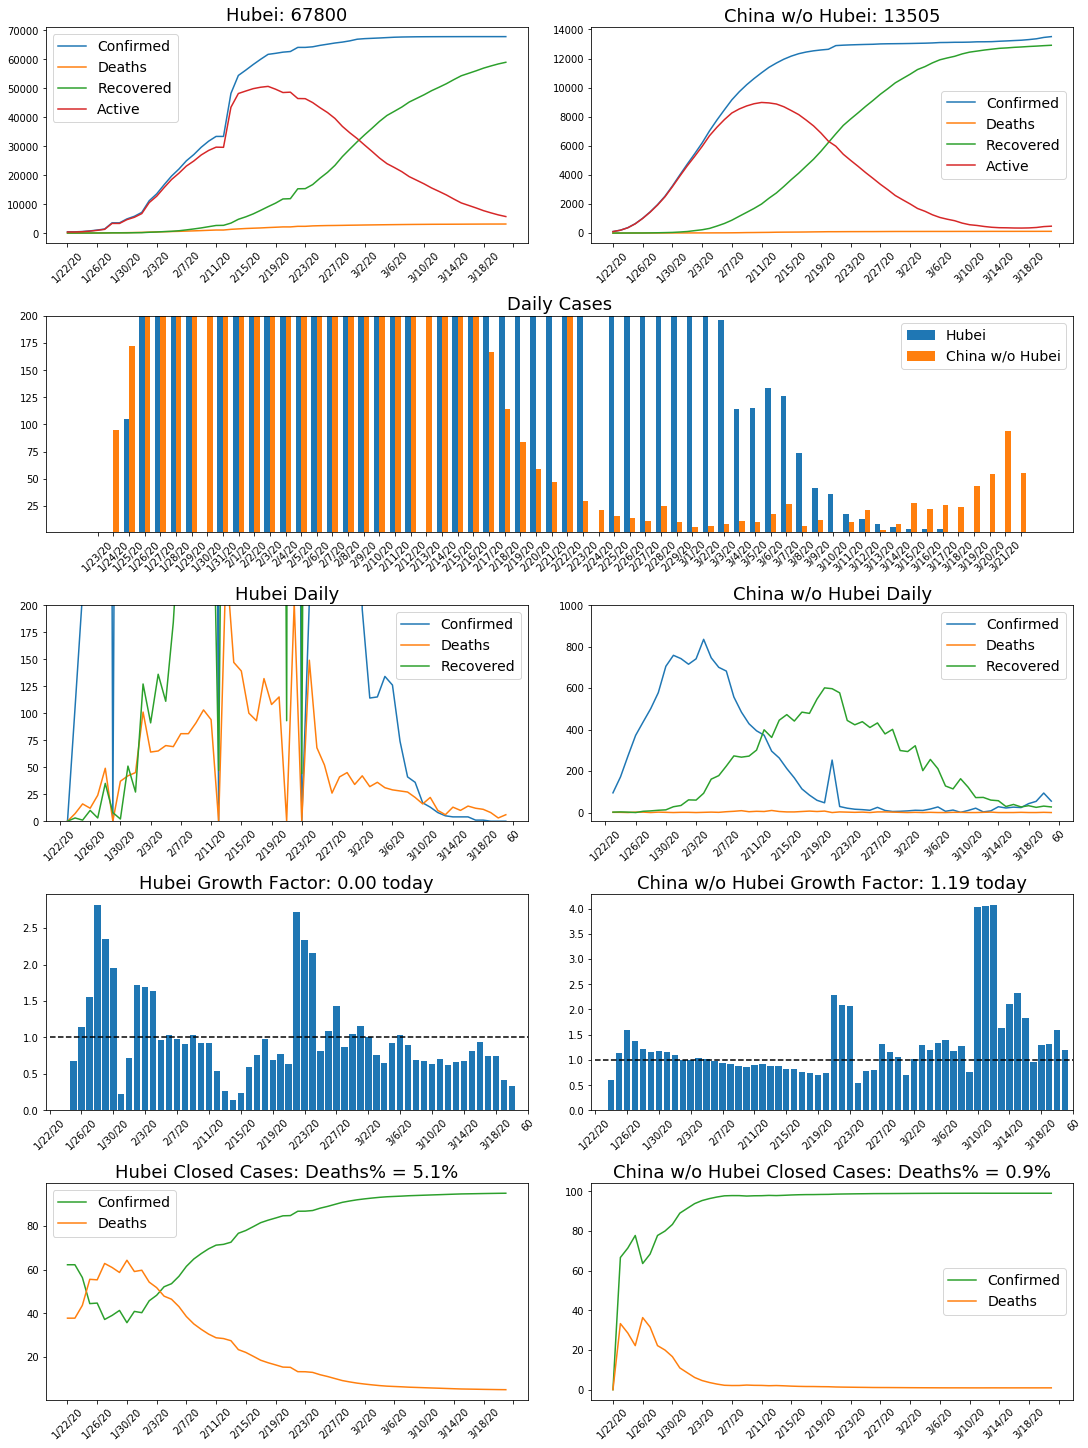

In [123]:
prov = 'Hubei'
df_prov = df_time_series.groupby('Country/Region').get_group('China').groupby('Province/State').get_group(prov).groupby('Category').sum().loc[:,time_str]
df_prov = reshape_dataframe(df_prov, time_str)

fig = plt.figure(figsize = (15, 20), constrained_layout=True)
gs = fig.add_gridspec(5,2)

### Hubei total confirmed/death/recovered
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_prov[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cat_cols, fontsize = 14)
ax1.set_title(f'{prov}: {int(df_prov.loc[time_str[-1], "Confirmed"])}', size = 18)

              
### Other Provinces total confirmed/death/recovered
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_co[cat_cols])
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cat_cols, fontsize = 14)
ax2.set_title(f'China w/o Hubei: {int(df_co.loc[time_str[-1], "Confirmed"])}', size = 18)

### Daily new cases              
ax3 = fig.add_subplot(gs[1, :])
# hubei_daily = hubei.loc['Confirmed',:].to_numpy()[1:] - hubei.loc['Confirmed',:].to_numpy()[:-1]
# co_daily = china_others.loc['Confirmed',:].to_numpy()[1:] - china_others.loc['Confirmed',:].to_numpy()[0:-1]
x = np.arange(len(time_str))
width = 0.35
rects1 = ax3.bar(x - width/2, df_prov.Daily, width = width)
rects2 = ax3.bar(x + width/2, df_co.Daily, width = width)
# ax3.set_yscale('log')
ax3.set_yscale('linear')
ax3.set_ylim([0, 200])
a = ax3.set_xticks(x)
a = ax3.set_xticklabels(time_str[1:])
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend([prov, 'China w/o Hubei'], fontsize = 14)
ax3.set_ylim(bottom = 10**-0.1)
ax3.set_title('Daily Cases', size = 18)

### Hubei daily confirmed/death/recovered              
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(df_prov[cat_cols[:-1]].diff())
ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ymax = np.max(df_prov[cat_cols[:-1]].diff().to_numpy()[1:,:].flatten())
ax4.set_ylim([0, min(ymax + 5, 200)])
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.legend(cat_cols[:-1], fontsize = 14)
ax4.set_title(f'{prov} Daily', size = 18)

### Other provinces daily confirmed/death/recovered              
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(df_co[cat_cols[:-1]].diff())
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(cat_cols[:-1], fontsize = 14)
ax5.set_ylim(top = 1000)
ax5.set_title('China w/o Hubei Daily', size = 18)

### Hubei Growth Factor
ax6 = fig.add_subplot(gs[3, 0])
x = np.arange(0, len(time_str))
x1 = np.arange(0, len(time_str) + 2)

ax6.bar(x, df_prov.GF_rolling)
ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.set_xlim([-0.5, len(x)])
ax6.tick_params(axis = 'x', labelrotation = 45)
_ = ax6.set_title(f'{prov} Growth Factor: {df_prov.GF_rolling[-1]:.2f} today', size = 18)

              
### Other Provinces Growth Factor
ax7 = fig.add_subplot(gs[3, 1])

ax7.bar(x, df_co.GF_rolling)
ax7.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax7.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax7.xaxis.set_major_locator(myLocator)
ax7.set_xlim([-0.5, len(x)])
ax7.tick_params(axis = 'x', labelrotation = 45)
_ = ax7.set_title(f'China w/o Hubei Growth Factor: {df_co.GF_rolling[-1]:.2f} today', size = 18)

                    
### Hubei Closed cases      
ax8 = fig.add_subplot(gs[4, 0])
ax8.plot(df_prov.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_prov.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(cat_cols, fontsize = 14)
ax8.set_title(f'{prov} Closed Cases: Deaths% = {df_prov.Death_prop[-1]:.1f}%', size = 18)

### Hubei Closed cases      
ax9 = fig.add_subplot(gs[4, 1])
ax9.plot(df_co.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_co.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(cat_cols, fontsize = 14)
_ = ax9.set_title(f'China w/o Hubei Closed Cases: Deaths% = {df_co.Death_prop[-1]:.1f}%', size = 18)

In [41]:
x = np.arange(len(time_str))
y1 = df_hb.Confirmed.to_list()
y2 = df_co.Confirmed.to_list()
# popt_exp, pcov_exp = opt.curve_fit(exp_growth,  t,  p_t)
popt1, pcov1 = opt.curve_fit(logistic_growth,  x,  y1, maxfev=10000)
popt2, pcov2 = opt.curve_fit(logistic_growth,  x,  y2, maxfev=10000)

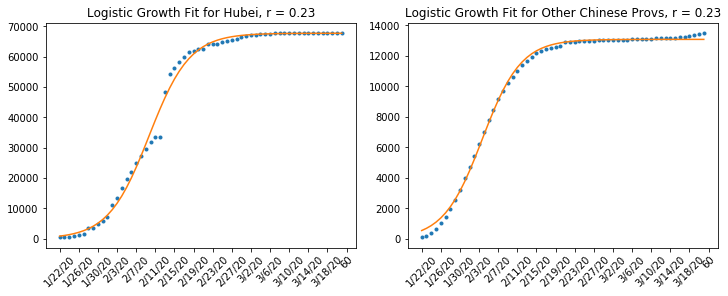

In [42]:
x1 = np.arange(len(x))

fig = plt.figure(figsize = (10, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
plt.plot(x, y1, '.')
plt.plot(x1, logistic_growth(x1, popt1[0], popt1[1], popt1[2]))
plt.title(f'Logistic Growth Fit for Hubei, r = {popt1[0]:.2f}')
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
# _ = ax1.set_xlim(right = len(time_str))


ax2 = fig.add_subplot(gs[0, 1])
plt.plot(x, y2, '.')
plt.plot(x, logistic_growth(x, popt2[0], popt2[1], popt2[2]))
plt.title(f'Logistic Growth Fit for Other Chinese Provs, r = {popt1[0]:.2f}')
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
# _ = ax2.set_xlim(right = len(time_str))

In [43]:
### world bar graph

In [44]:
df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_recovered.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)

In [45]:
# recovered = df_recovered.loc[:,time_str[-1]].to_numpy()
# deaths = df_deaths.loc[:,time_str[-1]].to_numpy()
# confirmed = df_confirmed.loc[:,time_str[-1]].to_numpy()
# x = np.arange(len(confirmed))

# fig, ax = plt.subplots(1,1,figsize = (40,6))
# rects = ax.bar(x, confirmed)
# plt.bar(x, deaths)
# plt.bar(x, recovered, bottom = deaths)

# plt.legend(['Confirmed', 'Recovered', 'Deaths'])
# plt.yscale('log')
# plt.ylim(bottom = 10**-0.1)
# plt.xlim([-1, len(x)])
# a = ax.set_xticks(x)
# a = ax.set_xticklabels(list(df_confirmed.index))
# a = plt.xticks(rotation=-90)
# a = plt.title(f'Total {len(df_confirmed.index)-4} Countries affected', fontsize = 18)
# autolabel(rects, ax, '{:.0f}')

In [46]:
""" Specific Countries """

' Specific Countries '

In [136]:
ctry = 'Italy'

In [137]:
df_ctry = pd.concat([df_confirmed.loc[ctry,time_str], 
                     df_deaths.loc[ctry,time_str],
                     df_recovered.loc[ctry,time_str]],
                    axis = 1)
df_ctry.columns = cat_cols[:3]
df_ctry = df_ctry.transpose()
df_ctry = reshape_dataframe(df_ctry, time_str)

In [138]:
x = np.arange(len(time_str))
y = df_ctry.Confirmed.to_list()

res = df_ctry[df_ctry.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
ind_t0 = max(0, time_str.index(res)-3)
t = np.arange(len(time_str))[ind_t0:]- ind_t0
pt = y[ind_t0:]

popt_exp, pcov_exp = opt.curve_fit(exp_growth,  t,  pt, maxfev = 10000)
popt_log, pcov_log = opt.curve_fit(logistic_growth,  t,  pt, p0 = (0.1, 100, 1), maxfev=100000)


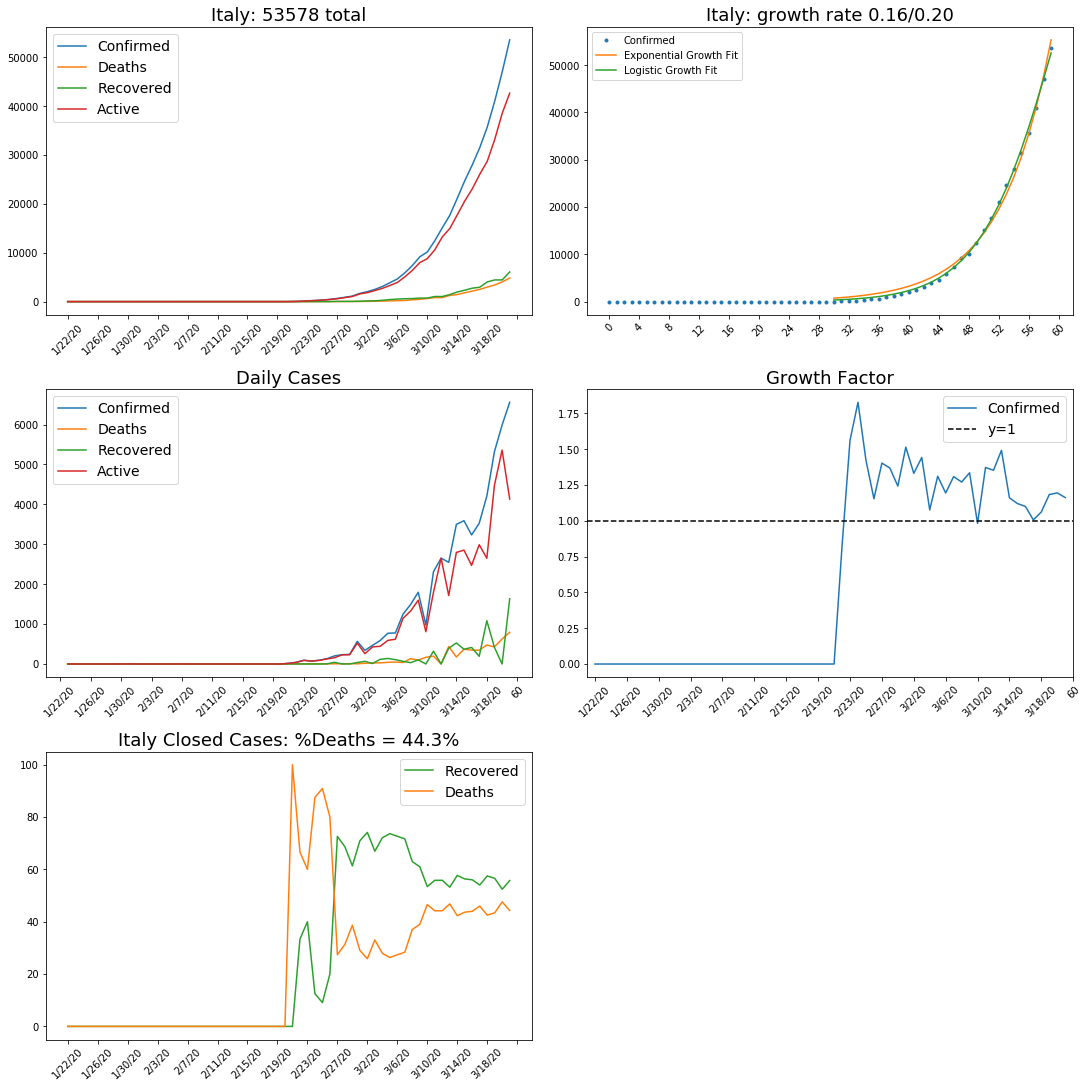

In [139]:
future = 0

fig = plt.figure(figsize = (15, 15), constrained_layout=True)
gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_ctry.loc[:, cat_cols])
# ax1.plot(df_deaths.loc[ctry, time_str].transpose())
# ax1.plot(df_recovered.loc[ctry, time_str].transpose())
# ax1.plot(df_active.loc[ctry, time_str].transpose())
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cat_cols, fontsize = 14)
ax1.set_title(f'{ctry}: {df_confirmed.loc[ctry, time_str[-1]]} total', size = 18)

ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(len(time_str))
x1 = np.arange(len(t) + future)
ax2.plot(x, y, '.')
if(future == 0):
    ax2.plot(x1 + ind_t0, exp_growth(x1, popt_exp[0], popt_exp[1]))
ax2.plot(x1 + ind_t0, logistic_growth(x1, popt_log[0], popt_log[1], popt_log[2]))
ax2.set_yscale('linear')
if(future == 0):
    ax2.legend(['Confirmed', 'Exponential Growth Fit', 'Logistic Growth Fit'])
else:
    ax2.legend(['Confirmed', 'Logistic Growth Fit'])
ax2.set_title(f'{ctry}: growth rate {popt_exp[0]:.2f}/{popt_log[0]:.2f}', fontsize = 18)
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)


ax5 = fig.add_subplot(gs[1, 0])
ax5.plot(df_ctry.loc[:,cat_cols].diff())
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(cat_cols, fontsize = 14)
ax5.set_title('Daily Cases', size = 18)

ax3 = fig.add_subplot(gs[1, 1])
x = np.arange(-1, len(time_str)+2)
ax3.plot(df_ctry.GF_rolling)
ax3.plot(x, np.full(len(x), 1), '--', color = 'k')
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['Confirmed', 'y=1'], fontsize = 14)
ax3.set_title('Growth Factor', size = 18)
ax3.set_xlim([-1, len(time_str)])

ax8 = fig.add_subplot(gs[2, 0])
ax8.plot(df_ctry.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_ctry.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(['Recovered', 'Deaths'], fontsize = 14)
_ = ax8.set_title(f'{ctry} Closed Cases: %Deaths = {df_ctry.Death_prop[-1]:.1f}%', size = 18)


In [51]:
# colors = pl.cm.tab10(np.linspace(0,1,len(countries)))
# for i, ctr in enumerate(countries):
#     ax4.plot(df_gf[ctr], color = colors[i])
# x = np.arange(-1, len(time_str)+2)
# ax4.plot(x, np.full(len(x), 1), '--', color = 'k')

# ax4.legend(countries, loc = 'upper left')
# ax4.set_yscale('linear')
# ax4.set_ylim([0, 5])
# a = ax4.set_title('Growth Factors: top 10 countries with most new cases')
# ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(4)
# ax4.xaxis.set_major_locator(myLocator)
# ax4.set_xlim(left = -1, right = len(time_str))
# ax4.tick_params(axis = 'x', labelrotation = 45)

# growth_factors = (df_confirmed.loc[countries, time_str[2:]].to_numpy() - df_confirmed.loc[countries, time_str[1:-1]].to_numpy()) \
# /(df_confirmed.loc[countries, time_str[1:-1]].to_numpy() - df_confirmed.loc[countries, time_str[:-2]].to_numpy())
# y = (growth_factors[:,-1] + growth_factors[:,-2])/2
# y[~np.isfinite(y)] = 0
# y = df_gf.loc[time_str[-1],:]

# # rects = ax5.bar(x[y<=1], y[y<=1], color = 'tab:blue')
# # rects = ax5.bar(x[y>1], y[y>1], color = 'tab:red')

# a = ax5.set_xticks(x)
# a = ax5.set_xticklabels(countries)
# ax5.tick_params(axis = 'x', labelrotation = -90)
# autolabel(rects, ax5, '{:.2f}')
# ymax = np.ceil(np.max(y)) + 1
# ax5.set_ylim([0, ymax])
# a = ax5.set_title('Growth Factor of places w/ >100 confirmed cases')